# Testing ZNE on noisy quantum computers


**Description**

Runs various error mitigation techniques (ZNE and PEC) on various hardware or simulator offerings with different benchmark circuits (randomized benchmark or mirror). Built off sample code from `Mitiq` and a couple functions written by Rebecca :D

**Options**
* Number of qubits: 1 to 21 for now
* Max scale factor: up to 9
* Max depth: up to whenever they converge 
* Folding type: global vs. the two types of local folding
* Type of circuit: mirror, long CNOT, and a fun bonus one 


#### Things to note:

* If `scale_factor` is not an odd integer and if the input circuit is very short, there can be a large error in the actual scaling of the number of gates. For this reason, when dealing with very short circuits, we suggest to use odd integer scale factors
* Some `Cirq` funcitonality occassionally breaks with newer versions of other packages, for some reason tuning everything into a function seems to fix most of the issues? 

## Setup


In [44]:
import functools
import os
import time
from typing import List

import matplotlib.pyplot as plt

plt.rcParams.update({"font.family": "serif", "font.size": 15})
%matplotlib inline

import cirq
import networkx as nx
import numpy as np
import qiskit
import qiskit_aer
from qiskit_ibm_runtime.fake_provider import FakeLimaV2, FakeKolkataV2, FakeSherbrooke 
from qiskit.providers.fake_provider import GenericBackendV2
from mitiq import benchmarks, pec, zne

## Problem definition


### Parameters


In [2]:
# Option to use a noisy simulator instead of hardware backend.
use_noisy_simulator: bool = True

# Minimum depth circuit to use.
min_depth: int = 1
# Random seed for circuit generation.
seed: int = 1

# Minimum noise scale factor.
min_scale_factor: int = 1
# Maximum noise scale factor.
max_scale_factor: int = 3

# Step between noise scale factors.
step_scale_factor: int = 1

# Total number of shots to use.
# For ZNE, the shots per circuit is shots / len(scale_factors).
shots: int = 10_000

# Display verbose output.
verbose: bool = True
# Give queue updates every this many seconds when running on hardware device.
verbose_update_time: int = 30

# Save data (cnot_counts, oneq_counts, true_values, noisy_values, zne_values, etc.).
save_data: bool = True


### Circuit parameters


In [81]:
# Benchmark circuit type. Supported types are "rb" and "mirror".
# RB circuits are only suppported for 1 and 2 qubit circuits.
circuit_type: str = "mirror"

# Qubits to use on the experiment.
num_qubits = 12
qubits = [j for j in range(num_qubits)]

# Maximum depth circuit to use.
max_depth: int = 50

# Step to create a list of depths to run at.
step_depth: int = 2

# Average results over this many trials (circuit instances) at each depth.
trials: int = 4

ideal_backend = qiskit_aer.AerSimulator()

noisy_backend = FakeKolkataV2()

### Hardware parameters


In [82]:
# Hardware backend device type. Supported types are currently "ibmq" but more could be added.
hardware_type: str = "ibmq"

backend = {
    "ibmq": "ibm_kolkata",
}.get(hardware_type)

### IBM qubit settings


In [83]:
def get_phys_qubits(n_qubits): # Borrowed from Rebecca's notebook
    # Physical qubits with a chain-like connectivity.
    ibm_lima_ordering = [0, 1, 3, 4, 2] # Up to 5 qubits
    ibm_kolkata_ordering = [0, 1, 4, 7, 10, 12, 15, 18, 21, 23, 24, 25, 22, 19, 16, 14, 11, 8, 5, 3, 2] # Up to 21 qubits
    ibm_sherbrooke_ordering = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 30, 29, 28, 27, 26, 25, 24, 
                               23, 22, 21, 20, 33, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 55, 68, 
                               67, 66, 65, 64, 63, 62, 61, 60, 59, 58]
    
    if n_qubits <= 5:
        # Assume ibmq-lima device. Take n adjacent physical qubits.
        physical_ibm_qubits = ibm_lima_ordering[: n_qubits]
    elif n_qubits <= len(ibm_kolkata_ordering) and n_qubits > 5:
        # Assume ibmq-kolkata device. Take n adjacent physical qubits.
        physical_ibm_qubits = ibm_kolkata_ordering[: n_qubits]
    else:
        raise ValueError(f"Number of qubits {n_qubits} too large.")
    
    return physical_ibm_qubits

### Error mitigation options


In [84]:
# Error mitigation type. Supported typed are "zne" and "pec".
mitigation_type: str = "zne"

fold_method = zne.scaling.fold_global # Global folding
# Other options are fold_gates_at_random() and fold_all() for local folding

depths = list(range(min_depth, max_depth + 1, step_depth))

scale_factors = tuple(range(min_scale_factor, max_scale_factor + 1, step_scale_factor))

print(f"Depths: {depths}")
print(f"Scale factors: {scale_factors}")

Depths: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]
Scale factors: (1, 2, 3)


### Hardware architecture

If the user selects the option to run on an actual hardware offering, define the architectural layout of the quantum device. Otherwise, invoke the appropriate simulator.


In [85]:
def get_computer(n_qubits):
    # Make connectivity graph 
    computer = nx.Graph()

    qubits = [j for j in range(n_qubits)]

    # Split qubits into 2-qubit pairs (assuming a chain connectivity).
    rb_pattern = [[qa, qb] for qa, qb in zip(qubits[0:-1:2], qubits[1::2])]
    if n_qubits % 2 == 1:
        # For an odd number of qubits, append final individual qubit to the RB pattern.
        rb_pattern.append([qubits[-1]])
    # print("Qubit indeces:", qubits)
    # print("RB pattern:", rb_pattern)

    # Assume chain-like connectivity
    computer.add_edges_from([(qa, qb) for qa, qb in zip(qubits[:-1], qubits[1:])])

    # Add reversed edges to computer graph.
    # This is important to represent CNOT gates with target and control reversed.
    computer = nx.to_directed(computer)
    return computer

In [86]:
def get_circuit(circuit_type:str, n_qubits:int, depth: int, seed: int) -> tuple[qiskit.QuantumCircuit, str]:
    """Create circuit."""
    
    if circuit_type == "rb":
        circuit = benchmarks.generate_rb_circuits(
            n_qubits=2, 
            num_cliffords=depth, 
            seed=seed, 
            return_type="qiskit"
            )[0]
        return circuit, "00"

    elif circuit_type == "mirror":
        # Make connectivity graph 
        computer = get_computer(n_qubits)
        circuit, correct_bitstring = benchmarks.generate_mirror_circuit(
                nlayers=depth,
                two_qubit_gate_prob=1.0,
                connectivity_graph=computer,
                two_qubit_gate_name="CNOT",
                seed=seed,
                return_type="qiskit",
            )
        # Reversed because Qiskit is wrong endian.
        return circuit, "".join(map(str, correct_bitstring[::-1]))
    
    else:
        print("what")
        return


### Benchmark circuit


In [87]:
def named_qubit_to_line_qubit(named_qubit: str) -> cirq.LineQubit:
    """Extract qubit number assuming "_" is used as a word separator."""
    digits = [int(s) for s in named_qubit.name.split("_") if s.isdigit()]
    if len(digits) == 1:
        return cirq.LineQubit(digits[0])
    else:
        raise RuntimeError("Failed to identify qubit number.")

### Operation representations


In [88]:
def get_cnot_error(edge: tuple[int, int] = None) -> float:
    # If we use a simulator, we can't get any error probability from any specific
    # device so we hardcode a small "reasonable" CNOT error probability.
    # if use_noisy_simulator and hardware_type != "ibmq":
    #cnot_error_prob = 0.01

    cnot_error_prob = noisy_backend.properties().gate_error("cx", qubits=edge)

    print(f"cnot_error_prob for edge {edge}: {cnot_error_prob}")
    return cnot_error_prob


def get_cnot_representation(edge: tuple[int, int]) -> pec.OperationRepresentation:
    cnot_circuit = cirq.Circuit(
        cirq.CNOT(
            cirq.NamedQubit(f"q_{str(edge[0])}"),
            cirq.NamedQubit(f"q_{str(edge[1])}"),
        )
    )

    rep_exact_prob = 1 - np.sqrt(1 - get_cnot_error(edge))
    return pec.represent_operation_with_local_depolarizing_noise(
        cnot_circuit,
        noise_level=rep_exact_prob,
    )


def get_representations(computer: nx.Graph) -> list[pec.OperationRepresentation]:
    return [get_cnot_representation(edge) for edge in computer.edges]

### CNOT count utility functions


In [89]:
def get_num_cnot_count(circuit: qiskit.QuantumCircuit) -> int:
    """Determine number of cnot gates in a given `Circuit` object."""

    return circuit.count_ops().get("cx")


def get_avg_cnot_count(circuits: list[qiskit.QuantumCircuit]) -> float:
    """Determine average number of cnot gates present in
    list of `QuantumCircuit` objects."""

    return np.average([c.count_ops().get("cx") for c in circuits])


def get_oneq_count(circuit: qiskit.QuantumCircuit) -> int:
    return len(circuit) - get_num_cnot_count(circuit)

### Executor


In [90]:
from typing import Union

def execute(
    circuits: Union[qiskit.QuantumCircuit, list[qiskit.QuantumCircuit]],
    backend,
    shots: int,
    correct_bitstring: str,
    verbose: bool = verbose,
    is_noisy: bool = True,
) -> List[float]:
    """Executes the input circuit(s) and returns ⟨A⟩, where
    A = |correct_bitstring⟩⟨correct_bitstring| for each circuit.
    """
    if not isinstance(circuits, list):
        circuits = [circuits]

    if verbose:
        # Calculate average number of CNOT gates per circuit.
        print(f"Executing {len(circuits)} circuit(s) on {backend}.")
        print(f"Average cnot count in circuits: {get_avg_cnot_count(circuits)}")

    # Store all circuits to run in list to be returned.
    to_run: list[qiskit.QuantumCircuit] = []

    for circuit in circuits:
        circuit_to_run = circuit.copy()
        circuit_to_run.measure_all()
        to_run.append(
            qiskit.transpile(
                circuit_to_run,
                backend=backend,
                initial_layout=get_phys_qubits(circuit.num_qubits),
                optimization_level=0,  # Otherwise RB circuits are simplified to empty circuits.
            )
        )

    if verbose:
        # Calculate average number of CNOT gates per compiled circuit.
        print(f"Average cnot count in compiled circuits: {get_avg_cnot_count(to_run)}")

    # Run and get counts.
    job = backend.run(
        to_run,
        # Reset qubits to ground state after each sample.
        init_qubits=True,
        shots=shots,
    )
    # IBMQ uses online queue for processing jobs.
    if verbose and not use_noisy_simulator:
        time.sleep(3)
        while not job.in_final_state():
            print(f"Queue position: {job.queue_position()}")
            time.sleep(verbose_update_time)
        print()

    print(f"Correct bitstring: {correct_bitstring}")
    if len(circuits) == 1:
        return [job.result().get_counts().get(correct_bitstring, 0.0) / shots]
    return [
        count.get(correct_bitstring, 0.0) / shots for count in job.result().get_counts()
    ]

## Experiment


In [91]:
def run_experiment(depths, trials, n_qubits, shots, circuit_type):
    cnot_counts, oneq_counts = [], []
    true_values, noisy_values = [], []
    zne_values = []
    noise_scaled_expectation_values = []

    for depth in depths:
        print("Status: On depth", depth, end="\n\n")

        cnot_depth_counts, oneq_depth_counts = [], []
        true_depth_values, noisy_depth_values = [], []
        zne_depth_values = []
        #pec_depth_values = []

        noise_scaled_expectation_depth_values = []

        for trial in range(trials):
            # Local seed is calculated in this way to ensure that we don't get repeat values in loop.
            local_seed = 10**6 * depth + 10**3 * seed + trial

            circuit, correct_bitstring = get_circuit(circuit_type, n_qubits, depth, local_seed)

            (true_value,) = execute(
                circuit,
                ideal_backend,
                shots,
                correct_bitstring,
                verbose=verbose,
                is_noisy=False,
            )
            (noisy_value,) = execute(
                circuit,
                noisy_backend,
                shots,
                correct_bitstring,
                verbose=verbose,
                is_noisy=True,
            )

            
            zne_executor = functools.partial(
                execute,
                backend=noisy_backend,
                shots=shots // len(scale_factors),
                correct_bitstring=correct_bitstring,
                verbose=verbose,
            )
            richardson_factory = zne.inference.RichardsonFactory(
                scale_factors=scale_factors
            )
            zne_value = zne.execute_with_zne(
                circuit,
                zne_executor,
                scale_noise=fold_method,
                factory=richardson_factory,
            )
            zne_depth_values.append(zne_value)
            noise_scaled_expectation_depth_values.extend(
                richardson_factory.get_expectation_values()
            )

            cnot_depth_counts.append(get_num_cnot_count(circuit))
            oneq_depth_counts.append(get_oneq_count(circuit))

            true_depth_values.append(true_value)
            noisy_depth_values.append(noisy_value)

        cnot_counts.append(cnot_depth_counts)
        oneq_counts.append(oneq_depth_counts)

        true_values.append(true_depth_values)
        noisy_values.append(noisy_depth_values)

        noise_scaled_expectation_values.append(noise_scaled_expectation_depth_values)

        zne_values.append(zne_depth_values)
    return cnot_counts, oneq_counts, true_values, noisy_values, noise_scaled_expectation_values, zne_values

## Plot results


In [ ]:
cnot_counts, oneq_counts, true_values, noisy_values, noise_scaled_expectation_values, zne_values = run_experiment(depths = depths, trials = trials, 
                                                                                                                  n_qubits = num_qubits, shots = shots, circuit_type = circuit_type)

Status: On depth 1

Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 011000100111
Executing 1 circuit(s) on <qiskit_ibm_runtime.fake_provider.backends.kolkata.fake_kolkata.FakeKolkataV2 object at 0x126aa0d10>.
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 011000100111
Executing 3 circuit(s) on <qiskit_ibm_runtime.fake_provider.backends.kolkata.fake_kolkata.FakeKolkataV2 object at 0x126aa0d10>.
Average cnot count in circuits: 19.333333333333332
Average cnot count in compiled circuits: 19.333333333333332
Correct bitstring: 011000100111
Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 110010001001
Executing 1 circuit(s) on <qiskit_ibm_runtime.fake_provider.backends.kolkata.fake_kolkata.FakeKolkataV2 object at 0x126aa0

In [ ]:
avg_true_values = np.average(true_values, axis=1)
avg_noisy_values = np.average(noisy_values, axis=1)

std_true_values = np.std(true_values, axis=1, ddof=1)
std_noisy_values = np.std(noisy_values, axis=1, ddof=1)

avg_zne_values = np.average(zne_values, axis=1)
std_zne_values = np.std(zne_values, axis=1, ddof=1)


NameError: name 'true_values' is not defined

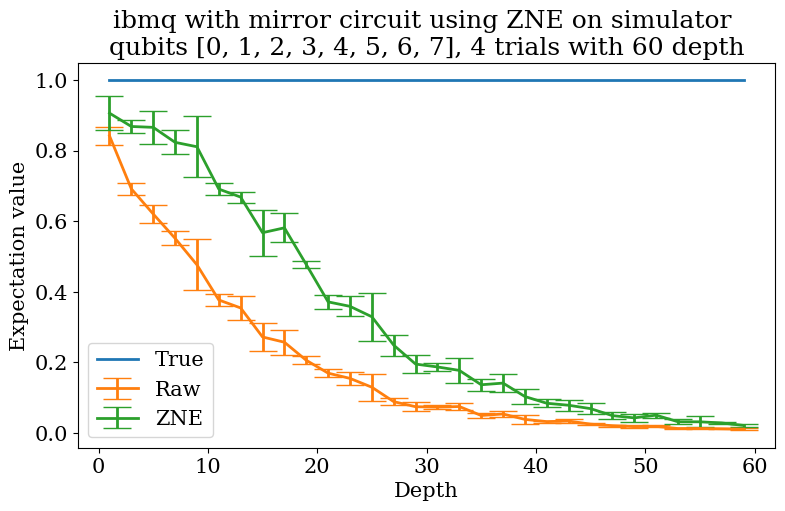

In [ ]:
plt.figure(figsize=(9, 5))

kwargs = {"capsize": 10, "lw": 2}

plt.plot(depths, avg_true_values, label="True", lw=2)
plt.errorbar(depths, avg_noisy_values, yerr=std_noisy_values, label="Raw", **kwargs)

if mitigation_type == "zne":
    plt.errorbar(depths, avg_zne_values, yerr=std_zne_values, label="ZNE", **kwargs)
#elif mitigation_type == "pec":
#    plt.errorbar(depths, avg_pec_values, yerr=std_pec_values, label="PEC", **kwargs)

plt.title(
    f"""{hardware_type} with {circuit_type} circuit using {mitigation_type.upper()} {"on simulator" if use_noisy_simulator else ""} \nqubits {qubits}, {trials} trials with {max_depth} depth"""
)
plt.xlabel("Depth")
plt.ylabel("Expectation value")
plt.savefig(f"{hardware_type}_{mitigation_type}_{circuit_type}_{qubits}qubits_{max_depth}depth.pdf")
plt.legend();

## Save data


In [ ]:
if save_data:
    dir_name = f"{hardware_type}_{mitigation_type}_{circuit_type}_nqubits_{len(qubits)}_mindepth_{min_depth}_maxdepth_{max_depth}_shots_{shots}_trials_{trials}"
    time_key = "_" + "_".join(time.asctime().split())

    try:
        os.mkdir(dir_name)
    except FileExistsError:
        pass

    np.savetxt(
        os.path.join(dir_name, "noise_scaled_expectation_values" + time_key + ".txt"),
        noise_scaled_expectation_values,
    )
    np.savetxt(os.path.join(dir_name, "cnot_counts" + time_key + ".txt"), cnot_counts)
    np.savetxt(os.path.join(dir_name, "oneq_counts" + time_key + ".txt"), oneq_counts)
    np.savetxt(os.path.join(dir_name, "true_values" + time_key + ".txt"), true_values)
    np.savetxt(os.path.join(dir_name, "noisy_values" + time_key + ".txt"), noisy_values)
    if mitigation_type == "zne":
        np.savetxt(os.path.join(dir_name, "zne_values" + time_key + ".txt"), zne_values)
    #elif mitigation_type == "pec":
    #    np.savetxt(os.path.join(dir_name, "pec_values" + time_key + ".txt"), pec_values)

    print("Data saved succesfully in", dir_name)

Data saved succesfully in ibmq_zne_mirror_nqubits_8_mindepth_1_maxdepth_60_shots_10000_trials_4


## Graphing 5-qubit device simulation

Figure saved to /Users/administrator/Downloads/5_qubit_device_simulator/2-5_qubits_to_convergence/ZNE_mirrorCircuit_globalFolding_5_qubit_device_summary.png


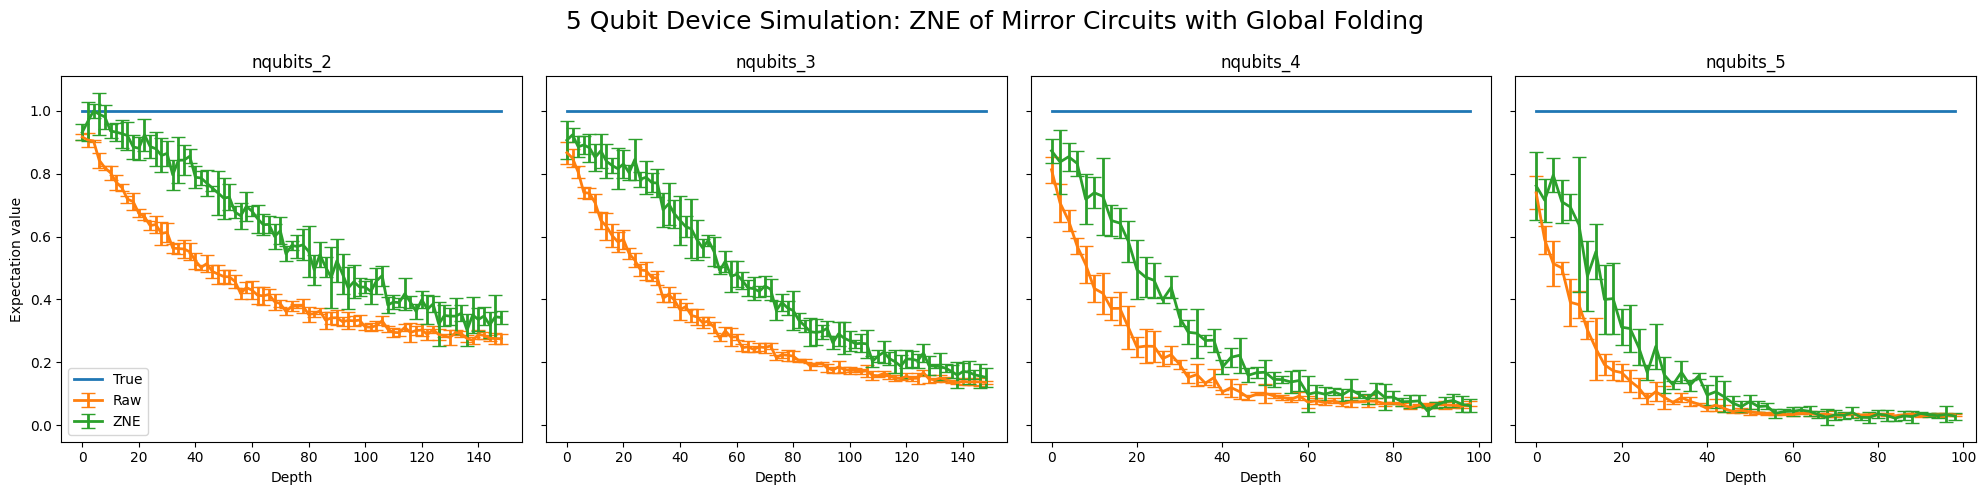

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob # For timestamps in files
import re # For plot name stuff 

base_dir = "/Users/administrator/Downloads/5_qubit_device_simulator/2-5_qubits_to_convergence" # I manually set up folders after running trials, will automate this for 5+ qubit device
subdirs = [
    os.path.join(base_dir, d)
    for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
]
subdirs = sorted(subdirs)[:4]  # Pick the first four for plotting

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)  # 1 row, 4 columns

for idx, subdir in enumerate(subdirs):
    ax = axs[idx]

    true_values = np.loadtxt(glob(os.path.join(subdir, "true_values" + "*.txt"))[0])
    noisy_values = np.loadtxt(glob(os.path.join(subdir, "noisy_values" + "*.txt"))[0])
    zne_values = np.loadtxt(glob(os.path.join(subdir, "zne_values" + "*.txt"))[0])

    avg_true_values = np.average(true_values, axis=1)
    avg_noisy_values = np.average(noisy_values, axis=1)
    avg_zne_values = np.average(zne_values, axis=1)
    
    # Depths are 0 to either 100 or 150
    depths = np.arange(0, true_values.shape[0] * 2, 2) 

    std_true_values = np.std(true_values, axis=1, ddof=1)
    std_noisy_values = np.std(noisy_values, axis=1, ddof=1)
    std_zne_values = np.std(zne_values, axis=1, ddof=1)

    kwargs = {"capsize": 5, "lw": 2}

    # Plot
    ax.plot(depths, avg_true_values, label="True", lw=2)
    ax.errorbar(depths, avg_noisy_values, yerr=std_noisy_values, label="Raw", **kwargs)
    ax.errorbar(depths, avg_zne_values, yerr=std_zne_values, label="ZNE", **kwargs)

    ax.set_xlabel("Depth")
    if idx == 0:
        ax.set_ylabel("Expectation value")

    # Set clean title
    folder_name = os.path.basename(subdir)
    match = re.search(r"nqubits_\d", folder_name)
    if match:
        title_str = match.group().replace("_mindepth_", ", ")
    else:
        title_str = folder_name
    ax.set_title(title_str)

axs[0].legend()  # Only first subplot has legend

save_path = os.path.join(base_dir, "ZNE_mirrorCircuit_globalFolding_5_qubit_device_summary.png")
fig.suptitle("5 Qubit Device Simulation: ZNE of Mirror Circuits with Global Folding", fontsize=18)
plt.tight_layout()
plt.savefig(save_path)
print(f"Figure saved to {save_path}")
